# LIBRARIES

In [16]:
import pandas as pd

import numpy as np

import os

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


import itertools

import matplotlib.pyplot as plt
from matplotlib import cm

# CONFIGURATION

In [17]:
sOutputSymbol = 'ETHUSD'
sModelType = 'MLP'

sFolderPath = 'Data/'+ sOutputSymbol +'//'+ sModelType + '//'

In [18]:
dfCentralCompositeDesign = pd.read_csv( sFolderPath + '\Central Composite Design\Design.csv', index_col = 'Run ID')
dfCentralCompositeExperiments = pd.read_csv( sFolderPath + '\Central Composite Design\Experiments.csv', index_col = 'Run ID')

# 2ND ORDER MODEL

In [19]:
oPolynomicalFeatures = PolynomialFeatures(degree = 2, include_bias = False)
dfFactors = pd.DataFrame(
    data = oPolynomicalFeatures.fit_transform(dfCentralCompositeDesign),
    columns  = oPolynomicalFeatures.get_feature_names_out(),
    index = dfCentralCompositeDesign.index
)

dfResponse = dfCentralCompositeExperiments['Response']

oLinearRegression  = LinearRegression()
oLinearRegression.fit(dfFactors, dfResponse)

LinearRegression()

## Coefficient of Determination

In [20]:
fRegressionScore = oLinearRegression.score(dfFactors, dfResponse)

## Equation

In [21]:
aRegressionCoeff = oLinearRegression.coef_
fRegressionIntercept =  oLinearRegression.intercept_

## Grid Search Optimization

In [23]:
aCombinations = np.array([])
i = 0
for sCol in dfCentralCompositeDesign.columns:
    if i == 0:
        aCombinations= np.arange(dfCentralCompositeDesign[sCol].min(), dfCentralCompositeDesign[sCol].max(), 1)
    else:
        aCombinations = itertools.product(aCombinations, np.arange(dfCentralCompositeDesign[sCol].min(), dfCentralCompositeDesign[sCol].max(), 1))
        
    i = i +1 

aCombinations = list(aCombinations)
dfCombinations = pd.DataFrame(aCombinations, 
             columns = dfCentralCompositeDesign.columns)

dfPolynomialCombinations = pd.DataFrame(data = oPolynomicalFeatures.transform(dfCombinations),
                              columns = oPolynomicalFeatures.get_feature_names_out()
                             )

dfCombinations['Response'] =  oLinearRegression.predict(dfPolynomialCombinations)

sDesignFolder = sFolderPath + '\\Response Surface Method\\'
os.makedirs(sDesignFolder, exist_ok = True)
dfCombinations.to_csv(sDesignFolder + 'Grid Search.csv', index=True, index_label='Run ID')

## Optimum Configuration

In [39]:
dfOptimumConfig = dfCombinations[dfCombinations['Response'] == dfCombinations['Response'].min()].head(1)

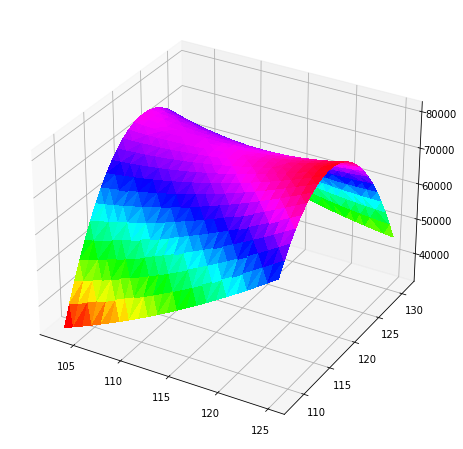

In [25]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(dfCombinations.iloc[:, 0], 
                dfCombinations.iloc[:, 1], 
                dfCombinations['Response'], 
                linewidth=0, 
                antialiased=False,
                cmap=cm.hsv
               )
fig.get_figure().savefig(sFolderPath + '\Response Surface Method\surface plot.png')
plt.show()

## Save Performance

In [74]:
dicPerformance=  {
    'Performance' : ['Regression Score', 'Feature Names' ,'Intercept', 'Coefficients', 'Hyperparameter Names', 'Optimum Hyperparameters', 'Optimum Response' ] ,
    'Value' : [fRegressionScore, 
               list(oPolynomicalFeatures.get_feature_names_out()),
               fRegressionIntercept, 
               list(aRegressionCoeff),
               list(dfOptimumConfig.iloc[:,:-1].columns), 
               list(dfOptimumConfig.iloc[0,:-1].values),  
               dfOptimumConfig.iloc[0,-1] ]
}

pd.DataFrame(dicPerformance).set_index('Performance').to_csv(sDesignFolder + '/dfPerformance.csv', index=True, index_label='Performance')